In [6]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

sns.set_theme()
    
paths = [f.path for f in os.scandir('target/criterion/') if f.is_dir()]
paths.remove('target/criterion/report')

report = {}

for path in paths:
    path_end = path.split('/')[-1].split(' ')
    function_name = path_end[0]
        
    size_paths = [f.path for f in os.scandir(path) if f.is_dir() and not f.path.endswith('report')]
        
    for size_path in size_paths:
        size = int(size_path.split('/')[-1])
        with open(os.path.join(size_path, 'base', 'estimates.json'), 'r') as f:
            data = json.load(f)
            
            if function_name not in report:
                report[function_name] = {}
                            
            report[function_name][size] = data['median']['point_estimate']
        

In [12]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
df = pd.DataFrame(report)
df

,cost_filter,cost_nft_transfer,cost_create_var,cost_analysis_iterable_func,cost_fold,cost_analysis_check_let,cost_analysis_type_lookup,cost_secp256k1recover,cost_contract_storage,cost_index_of,cost_user_function_application,cost_ft_balance,cost_trait_checker,cost_create_ft,cost_analysis_get_function_entry,cost_nft_owner,cost_nft_mint,cost_fetch_var,cost_nft_burn,cost_unwrap_err,cost_stx_balance,cost_le,cost_type_parse_step,cost_contract_of,cost_inner_type_check_cost,cost_eq,cost_hash160,cost_some_cons,cost_as_max_len,cost_analysis_type_check,cost_analysis_lookup_variable_const,cost_if,cost_ft_get_supply,cost_analysis_check_tuple_merge,cost_is_okay,cost_leq,cost_unwrap_err_or_ret,cost_mul,cost_analysis_type_annotate,cost_analysis_tuple_items_check,cost_keccak256,cost_int_cast,cost_at_block,cost_analysis_use_trait_entry,cost_fetch_entry,cost_tuple_cons,cost_asserts,cost_div,cost_default_to,cost_not,cost_lookup_function,cost_analysis_check_tuple_get,cost_create_nft,cost_principal_of,cost_contract_call,poison_microblock,cost_pow,cost_sha256,cost_unwrap_ret,cost_ast_parse,cost_analysis_check_tuple_cons,cost_load_contract,cost_xor,cost_tuple_merge,cost_mod,cost_analysis_lookup_function_types,cost_analysis_lookup_variable_depth,cost_append,cost_geq,cost_is_err,cost_print,cost_analysis_list_items_check,cost_try_ret,cost_lookup_variable_size,cost_sha512t256,cost_analysis_option_cons,cost_set_var,cost_analysis_bind_name,cost_log2,cost_analysis_visit,cost_or,cost_match,cost_ft_transfer,cost_begin,cost_secp256k1verify,cost_type_checker,cost_read_only,cost_analysis_lookup_function,cost_concat,cost_ft_mint,cost_err_cons,cost_set_entry,cost_len,cost_ast_cycle_detection,cost_ft_burn,cost_analysis_storage,cost_ge,cost_lookup_variable_depth,cost_is_some,cost_sqrti,cost_list_cons,cost_analysis_option_check,cost_let,cost_ok_cons,cost_sha512,cost_map,cost_bind_name,cost_block_info,cost_unwrap,cost_and,cost_add,cost_is_none,cost_stx_transfer,cost_arithmetic_only_checker,cost_tuple_get,cost_element_at,cost_create_map,cost_sub
1,278436.953993,424261.407658,59884371.5,7.660129e+04,312696.917763,8.376451e+04,7016.092937,8608096.75,339698616.5,325861.807308,1.448240e+04,325470.562261,NaN,NaN,NaN,629702.131393,383084.494444,313578.929362,555082.976759,165319.608381,191793310.5,NaN,3156.677513,27508708.75,14319.780657,9.952737e+04,176616.620265,139693.552183,305195.868708,3.270123e+03,9154.749544,119551.82904,292857.202429,1.644892e+05,172850.053346,NaN,200346.843656,106819.547890,10485.662242,4.512797e+04,162115.406258,104577.969643,4.878473e+06,NaN,42023163.25,1.392820e+05,95245.786932,105686.929688,156217.105556,106390.170238,NaN,317.650556,60250989.0,NaN,98677.064609,1.775717e+07,NaN,153021.105623,210007.652431,170382620.0,3.721997e+04,NaN,NaN,2.761967e+05,NaN,NaN,18033.573588,616002.32259,NaN,179879.965719,1.040722e+06,1.884137e+04,176953.753537,6983.331486,151758.346761,36222.64787,598731.990625,8.406367e+04,103695.218423,9964.808442,94616.867401,183930.969281,340713.81336,127783.187694,8.126810e+06,NaN,NaN,NaN,520343.53125,1.002471e+06,131771.107056,1.746238e+06,339818.4,1.006637e+05,358685.263367,NaN,NaN,11098.257485,147801.306319,107538.224662,161820.34837,70903.532242,174346.069444,138977.291016,150657.523933,1.787878e+06,162098.44936,6504510.875,185427.692849,94151.638315,106004.692294,147602.821831,6.712859e+06,NaN,7.325634e+04,293620.966931,NaN,110413.162214
32,NaN,NaN,61031400.5,2.662411e+06,NaN,8.658783e+05,27918.476885,NaN,331364843.0,NaN,4.610211e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55633.014483,2.660329e+05,NaN,NaN,NaN,4.135884e+05,NaN,NaN,NaN,3.047497e+06,NaN,NaN,NaN,NaN,73768.448130,2.686074e+05,NaN,NaN,NaN,NaN,NaN,1.224346e+06,NaN,NaN,NaN,NaN,NaN,4720.767564,59005681.5,NaN,NaN,NaN,NaN,NaN,NaN,175215227.0,1.295064e+06,NaN,NaN,3.770653e+06,NaN,NaN,122213.817778,NaN,NaN,NaN,NaN,4.483837e+05,NaN,45972.907258,NaN,NaN,NaN,3.586930e+05,NaN,NaN,155228.115246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.667338e+06,NaN,3

In [35]:
def estimate_params(df, name, transform):
    X = df.index.values.reshape(-1, 1)
    Y = df[name].values.reshape(-1, 1)
    X = X[np.logical_not(np.isnan(Y))].reshape(-1, 1)
    Y = Y[np.logical_not(np.isnan(Y))]
    X = transform(X)
#     Y = transform(Y)

    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)
    
    b = linear_regressor.intercept_
    if b < 0:
        b = max(Y[0] - linear_regressor.coef_, 0)
    a = linear_regressor.coef_
    
    return (a, b)
    
def logn(n):
    return np.log2(n)

def nlogn(n):
    return n * np.log2(n)

def plot(df, name, a, b, transform):
    Y = df[name].values.reshape(-1, 1)
    X = df.index.values.reshape(-1, 1)
    X = X[np.logical_not(np.isnan(Y))]
    X = transform(X)
    Y = Y[np.logical_not(np.isnan(Y))]
    
    y_pred = a*X + b
    
    plt.scatter(X, Y, color='orange')
    plt.suptitle(name)
    plt.plot(X, y_pred, color='blue')
    plt.show()

def estimate_plot(df, fun_name, output, transform = lambda x: x):
    a, b = estimate_params(df, fun_name, transform)
    print(a, b)
#     output.loc[fun_name] = [a.squeeze(), b.squeeze()]
    if not isinstance(a, int):
        a = a.squeeze()
    if not isinstance(b, int):
        b = b.squeeze()
    output.loc[fun_name] = [a, b]
    plot(df, fun_name, a, b, transform)

[2234.45295272] 8169.458349365683


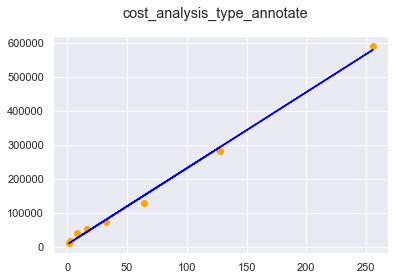

[76969.66136293] 0


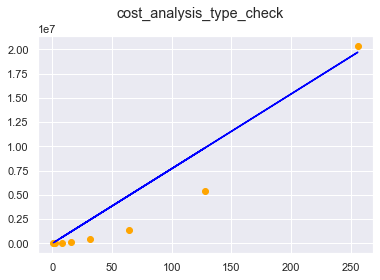

[956.96884622] 3762.0177488701665


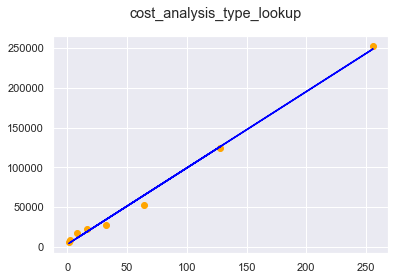

[0.] 9964.808442449183


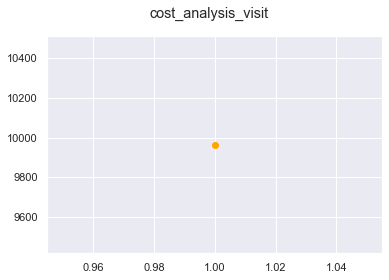

[158117.1697926] 0


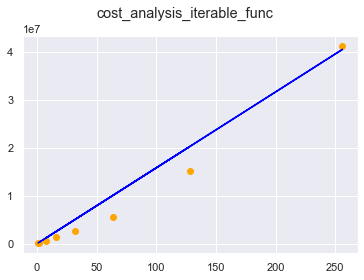

[0.] 36222.64787019459


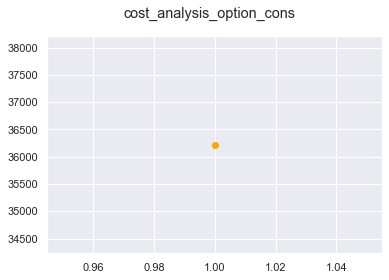

[0.] 70903.53224206349


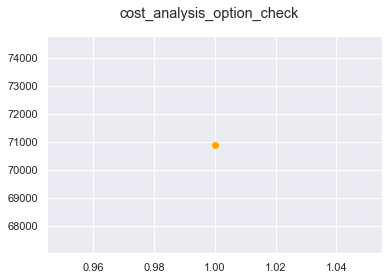

[8909.21042082] 104817.42672320746


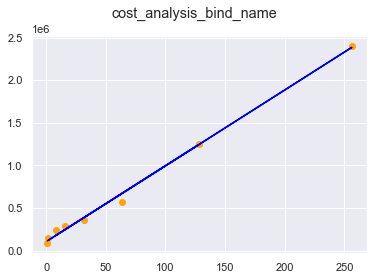

[15287.66038394] [3553.71048989]


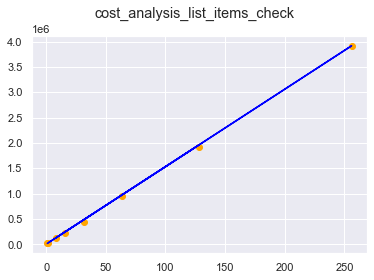

[18.5885287] 1202.7631116282664


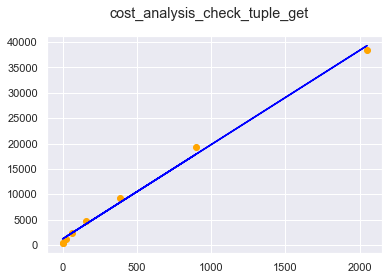

[6858.04846348] 93476.67501340527


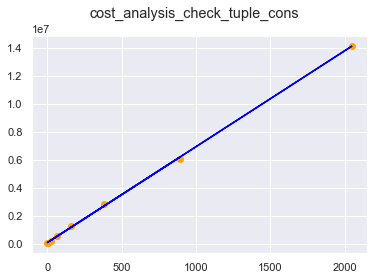

[8309.69904802] 33643.91938622389


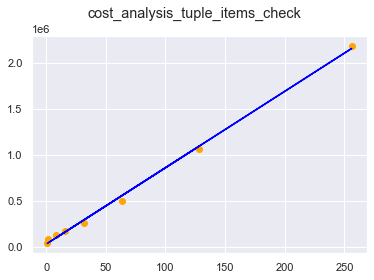

[27817.4341268] [55947.07262382]


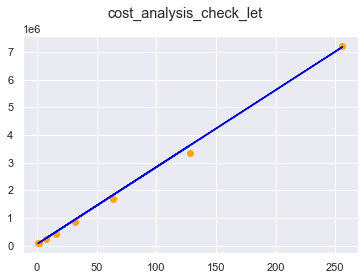

[0.] 11969.815014294465


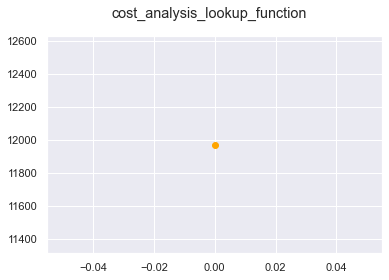

[973.4006124] 16829.04867988685


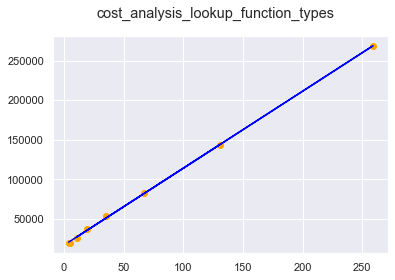

[0.] 9154.749544051629


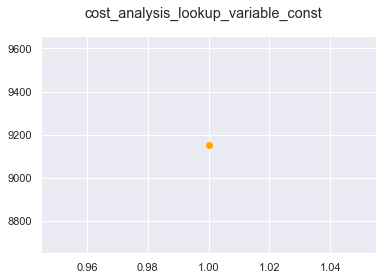

[447.91020454] 39241.32314564916


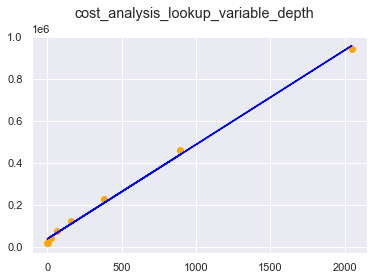

[175.52716021] 2436.976384789101


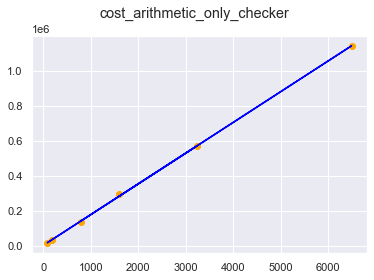

[524.49851171] [2953535.70737064]


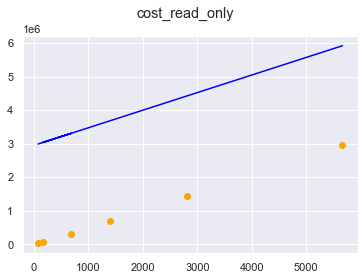

[62541.42133555] [1327884.56261968]


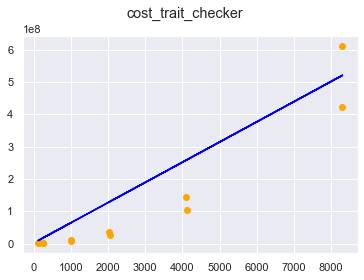

[35844.42268943] [1169717.29022266]


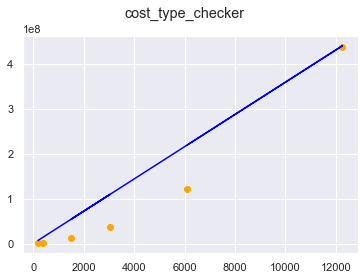

[103891.90736776] 171246838.18306813


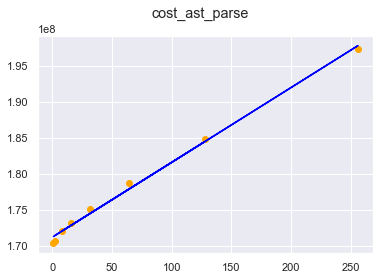

[85400.30939442] [15263.40520051]


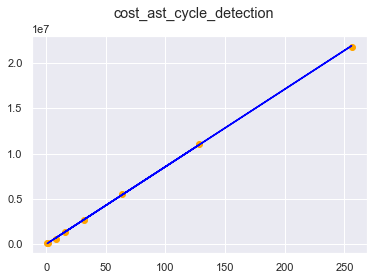

[103.34772636] [3149.65765477]


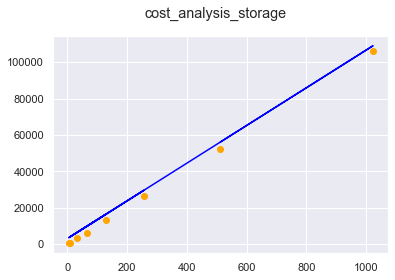

[6117.6421755] 444435.42383786966


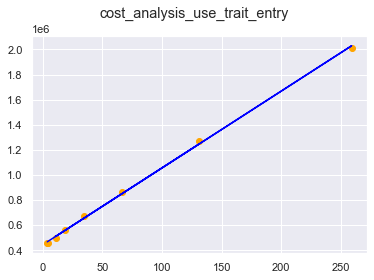

[48273.75092221] 802657.63110233


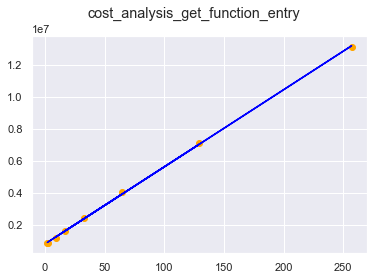

[1677.94724838] 8861.606348691115


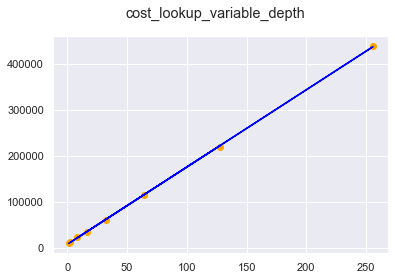

[1448.34469883] 338.19188900955487


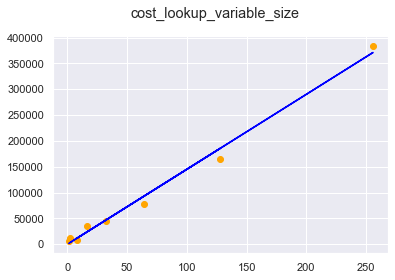

[0.] 15441.493160301896


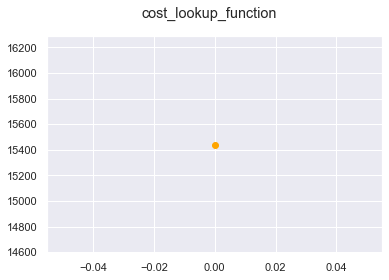

[0.] 162098.44936034115


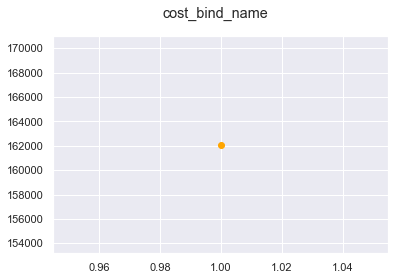

[1669.48800247] 6119.0397001816455


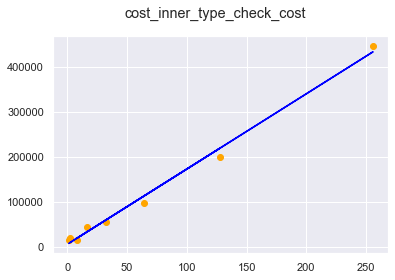

[16035.90078652] 0


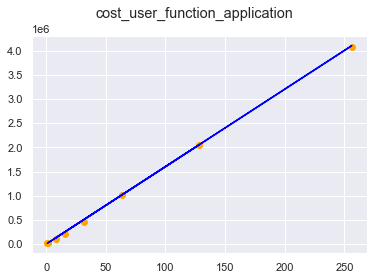

[0.] 174346.06944444444


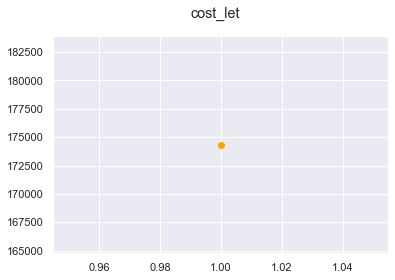

[0.] 119551.82904040403


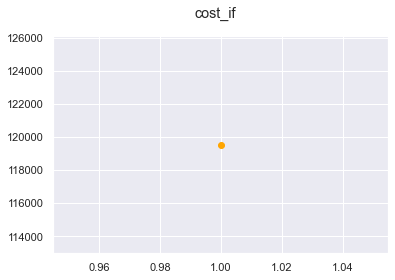

[0.] 95245.78693181818


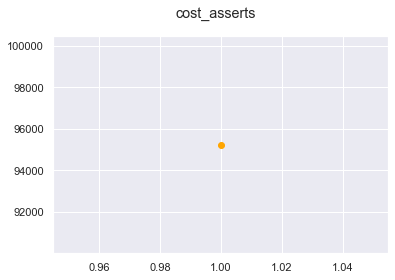

[709036.34855656] 1868007.55634927


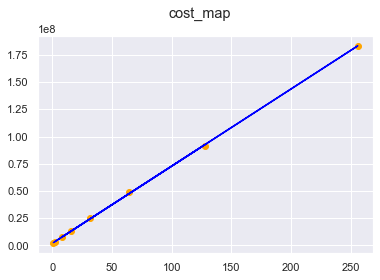

[0.] 278436.9539927405


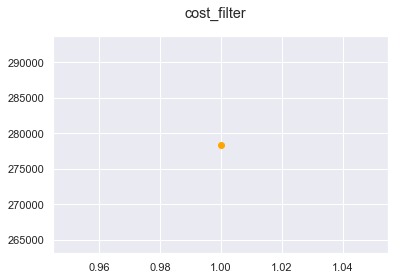

[0.] 339818.4


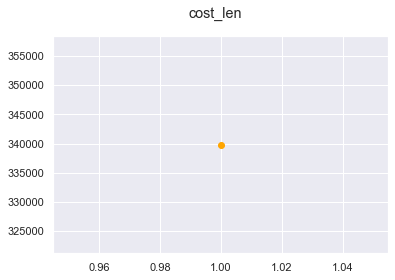

[0.] 293620.9669306507


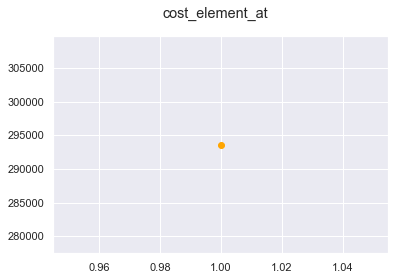

[0.] 325861.8073081801


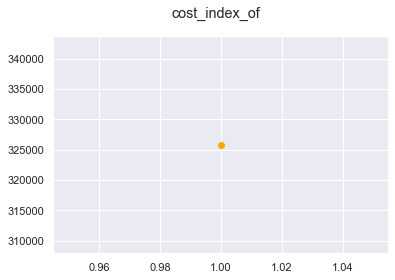

[0.] 312696.91776315786


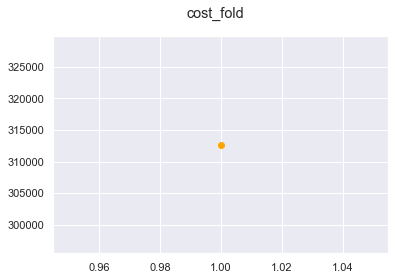

[0.] 161820.3483695652


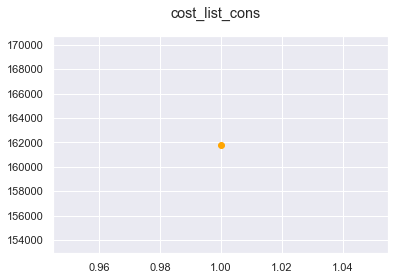

[0.] 3156.6775127844394


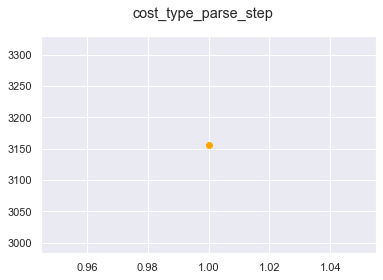

[2627.98284666] 1018650.8093795478


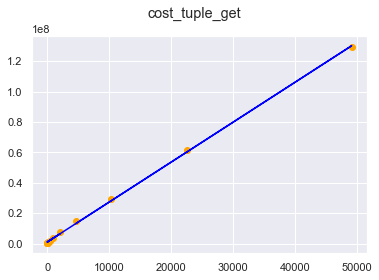

[127255.52199264] [148941.20027456]


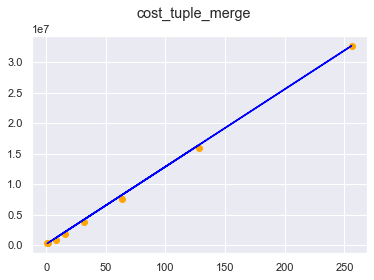

[6417.7272913] 1299665.3570570722


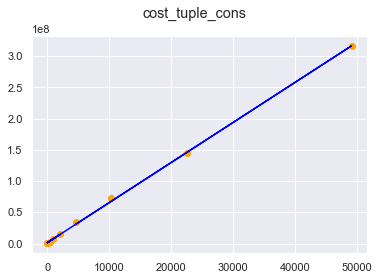

[6565.21248286] 102852.7388171902


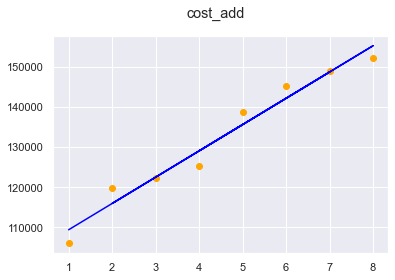

[6693.78506441] 102075.95287173988


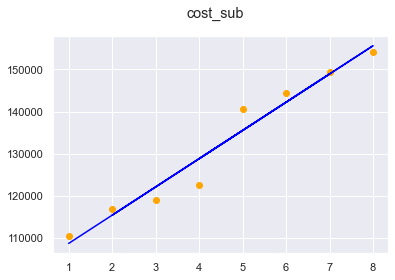

[7543.67470725] 101525.79477039288


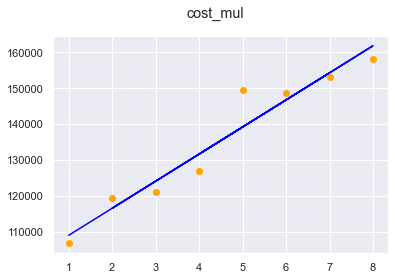

[7994.56095925] 99950.85517578825


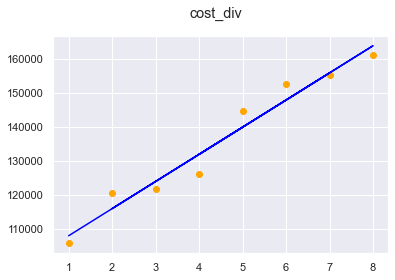

[0.] 107677.40465909091


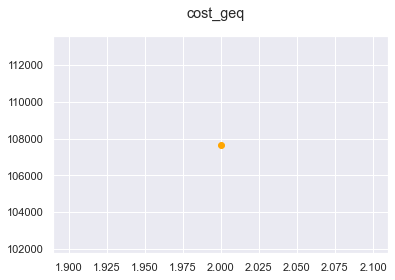

[0.] 107238.96906162465


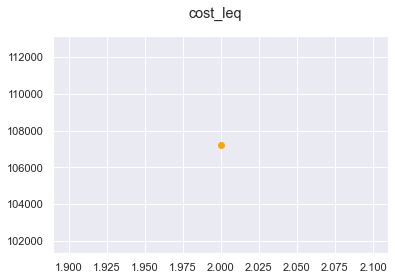

[0.] 101925.37118055555


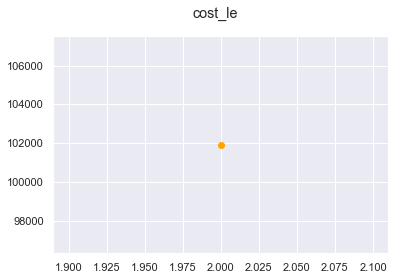

[0.] 102087.82846153846


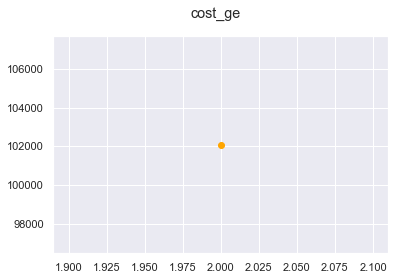

[0.] 104577.96964285715


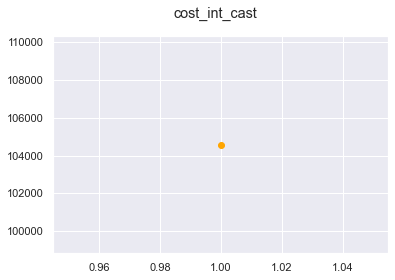

[0.] 110398.55


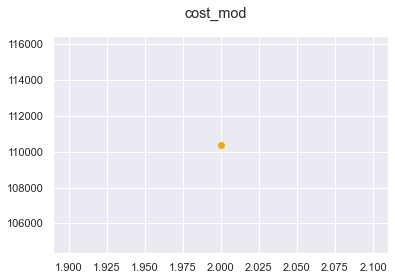

[0.] 111132.37433862433


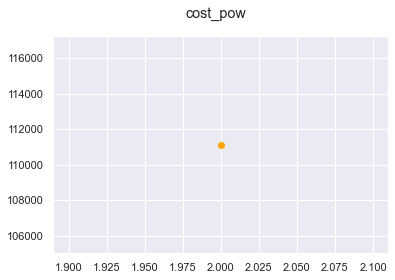

[0.] 107538.22466216216


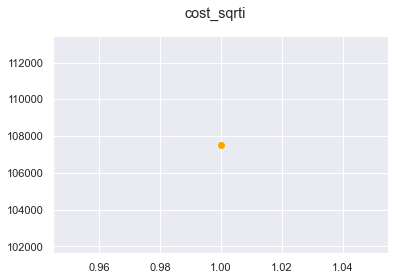

[0.] 103695.21842307692


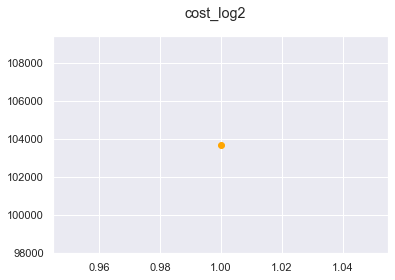

[0.] 107263.32573839661


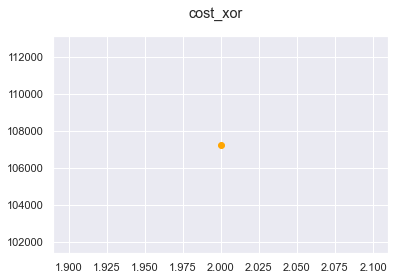

[0.] 106390.17023809525


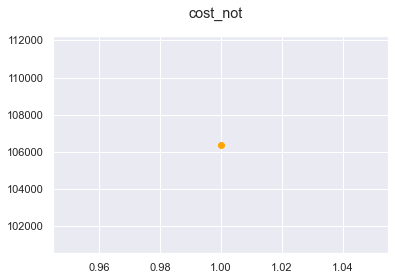

[4564.0237611] 109521.95193567628


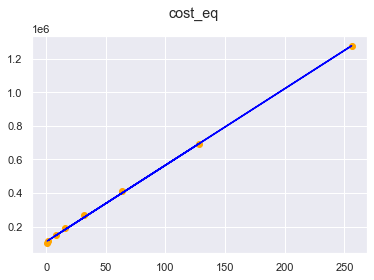

[0.] 127783.18769409938


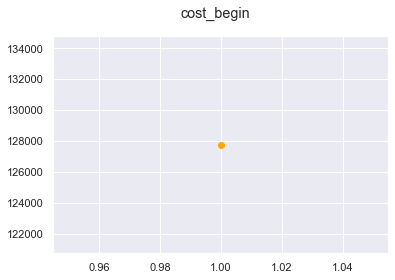

[0.] 176616.62026515152


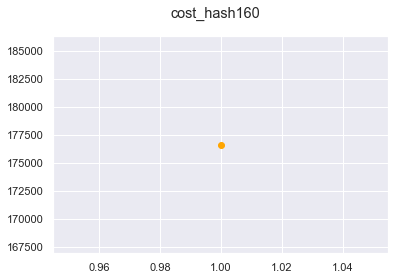

[0.] 153021.10562284157


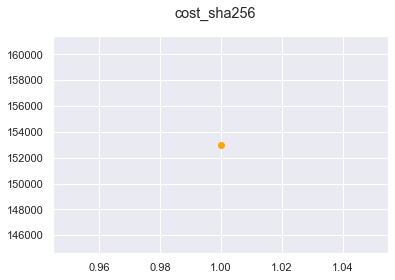

[0.] 150657.52393267653


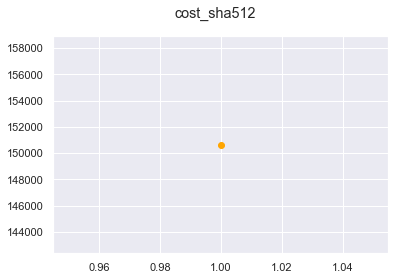

[0.] 151758.34676079734


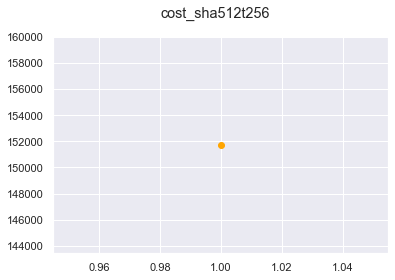

[0.] 162115.40625813167


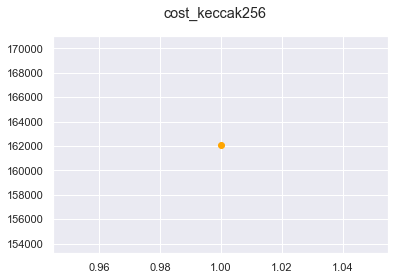

[0.] 8608096.75


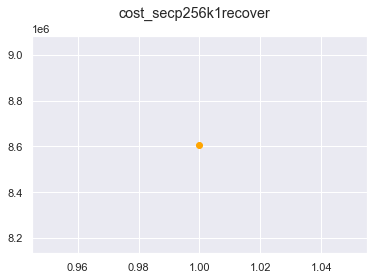

[0.] 8126809.571428571


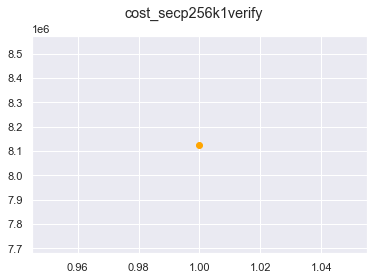

[0.] 1040721.9601449275


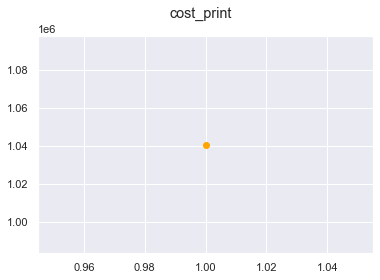

[0.] 139693.55218301434


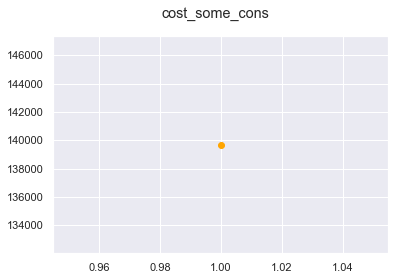

[0.] 138977.291015625


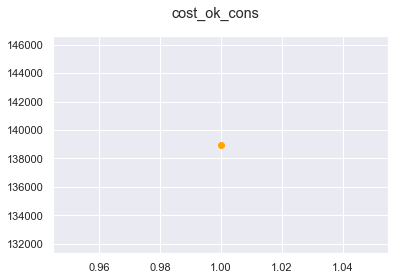

[0.] 131771.1070564516


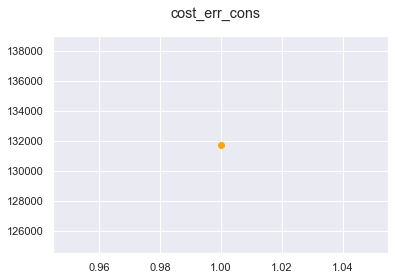

[0.] 156217.10555555555


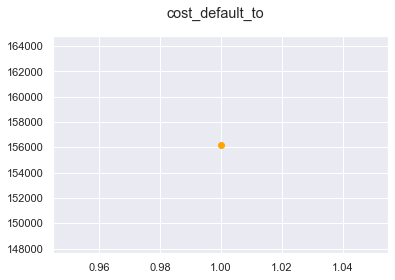

[0.] 210007.65243055555


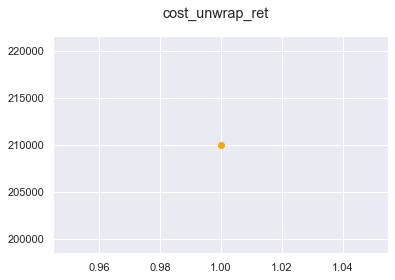

[0.] 200346.84365647368


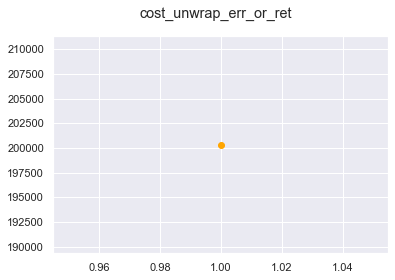

[0.] 172850.05334595958


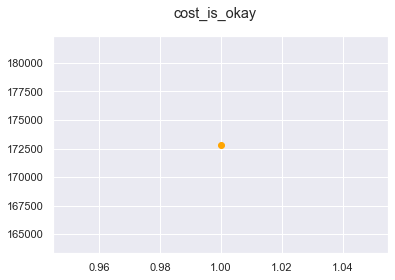

[0.] 147602.82183075935


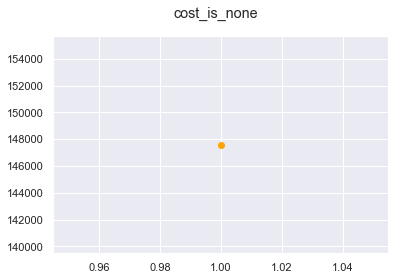

[0.] 179879.9657192076


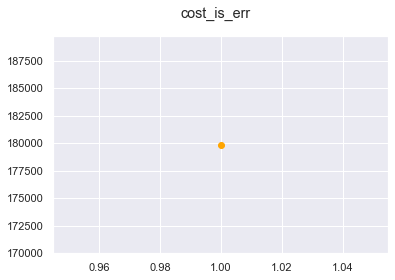

[0.] 147801.3063186813


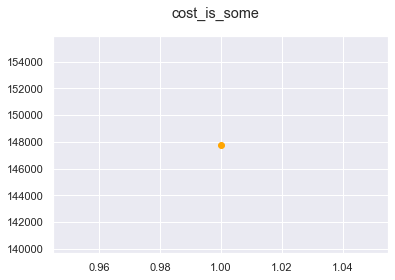

[0.] 185427.6928490991


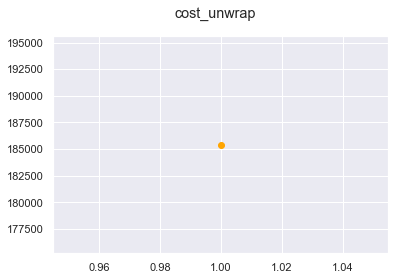

[0.] 165319.6083813094


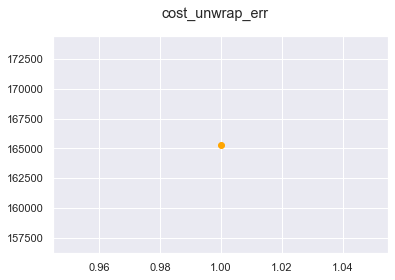

[0.] 176953.75353658537


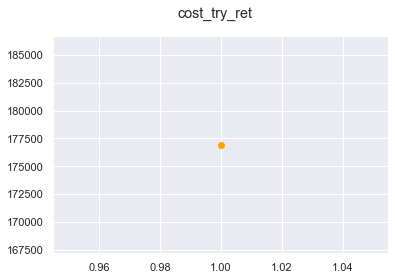

[0.] 183930.96928104575


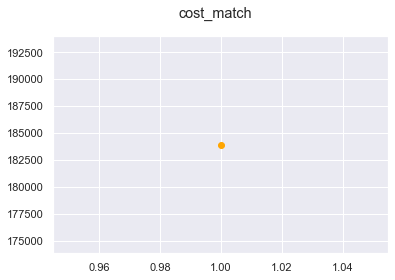

[2064.47134446] 91676.39715430875


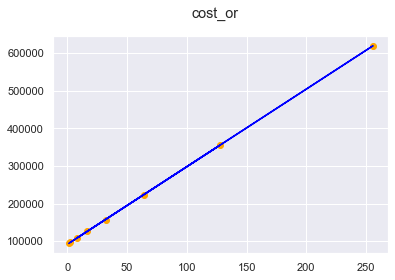

[2076.54360851] 92089.19135591891


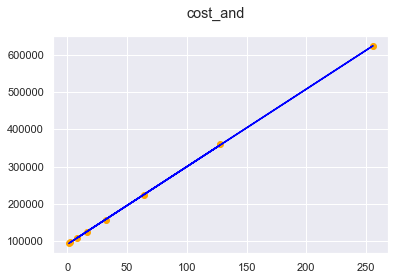

[0.] 616002.3225903613


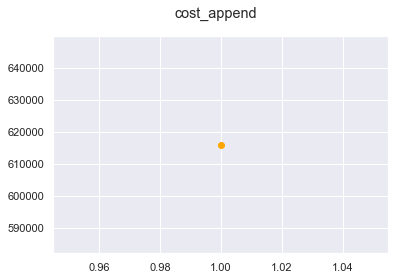

[0.] 520343.53125


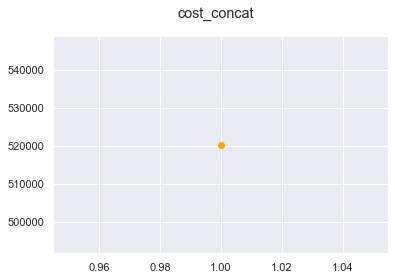

[0.] 305195.86870845204


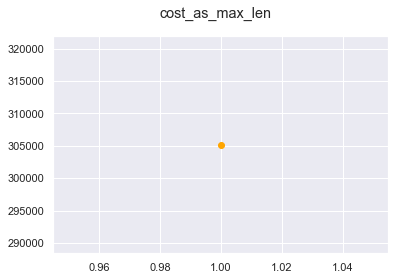

[0.] 98677.06460930375


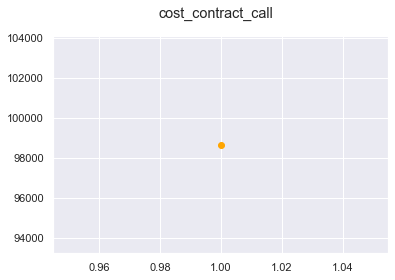

[0.] 27508708.75


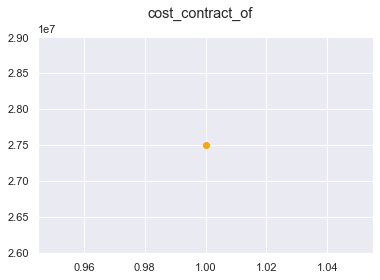

[0.] 21524.339285714283


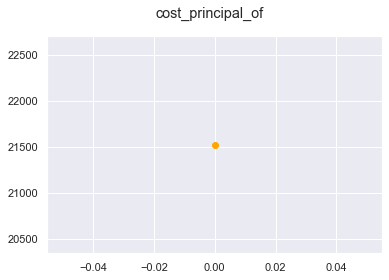

[0.] 4878473.363636363


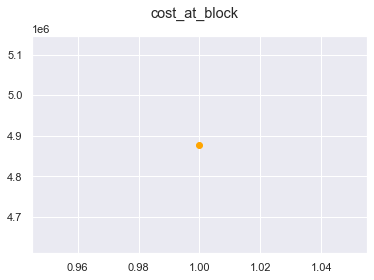

[132.21921299] [6312.19859143]


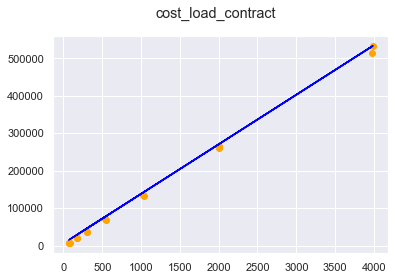

[-3527.12825463] 59306305.25639157


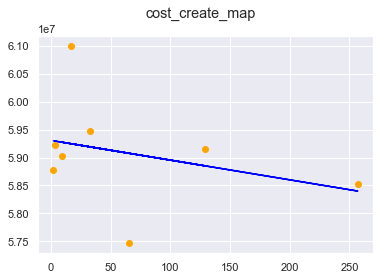

[18586.49993211] 59800667.254302725


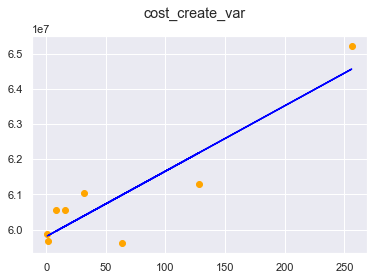

[3638.3803033] 58920692.02327829


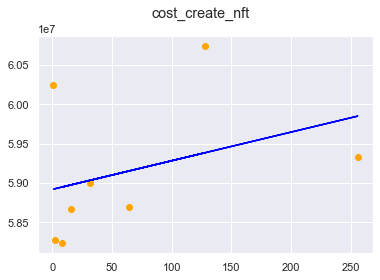

[0.] 59153733.5


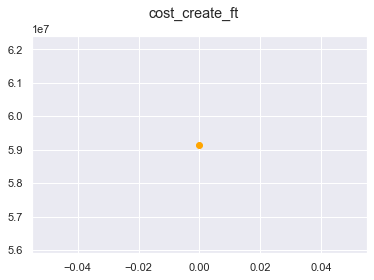

[0.] 42023163.25


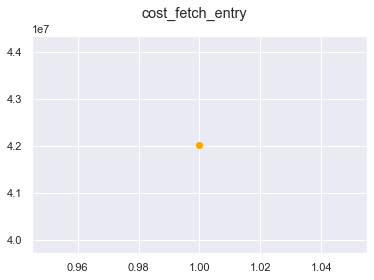

[0.] 1746237.7592105262


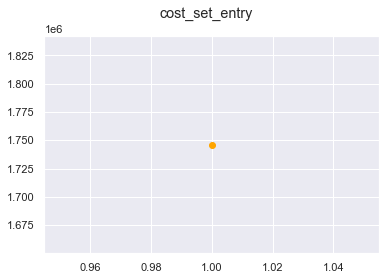

[0.] 313578.9293617021


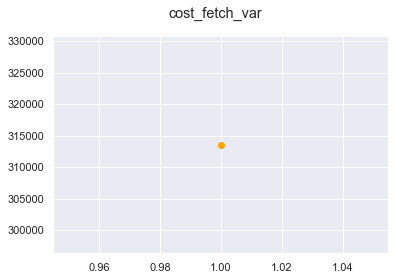

[0.] 598731.990625


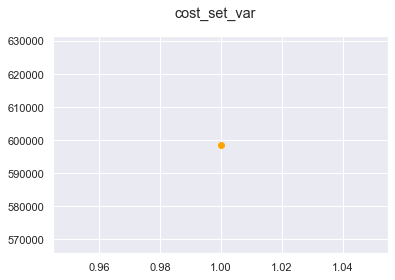

[-6949.83152889] 334718183.8856431


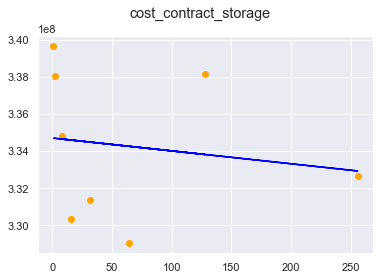

[0.] 6504510.875


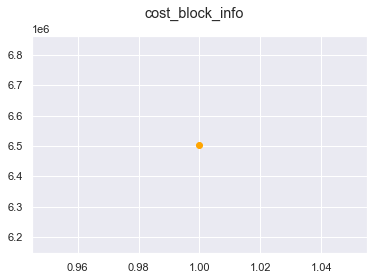

[0.] 191793310.5


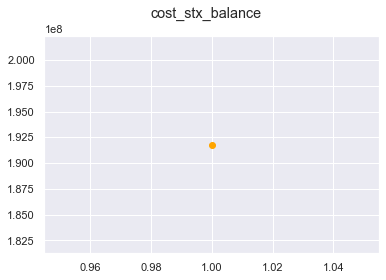

[0.] 6712859.3125


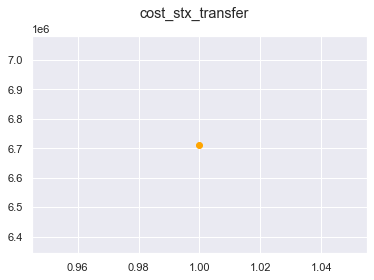

[0.] 1002470.9141606395


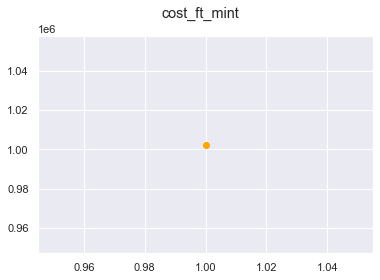

[0.] 340713.8133603239


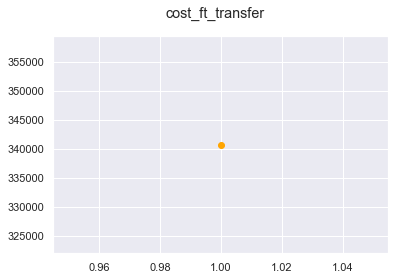

[0.] 325470.5622605364


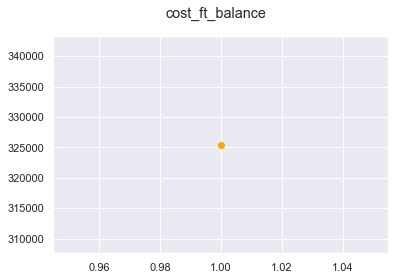

[0.] 383084.4944444444


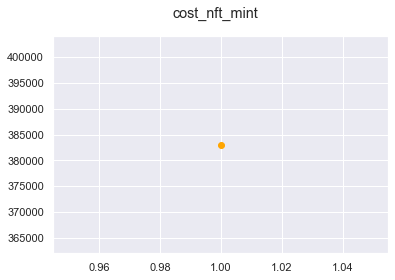

[0.] 424261.40765765763


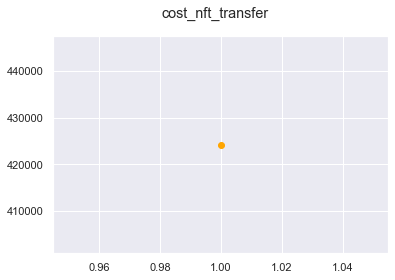

[0.] 629702.131393298


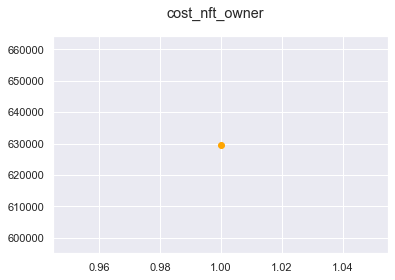

[0.] 292857.20242914977


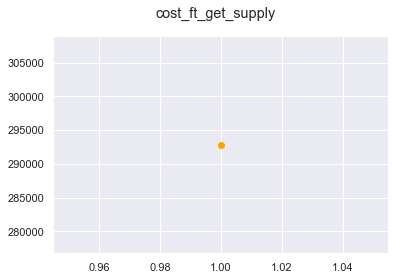

[0.] 358685.26336681016


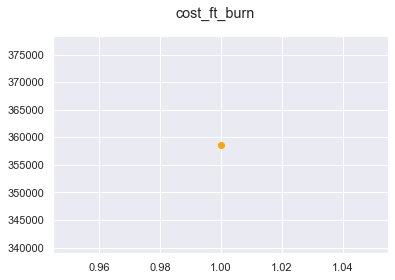

[0.] 555082.9767591166


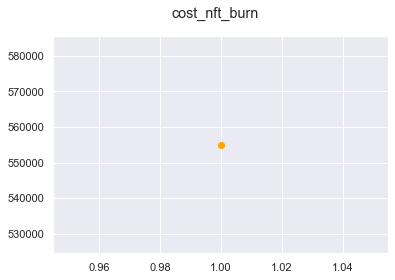

[0.] 17757165.166666664


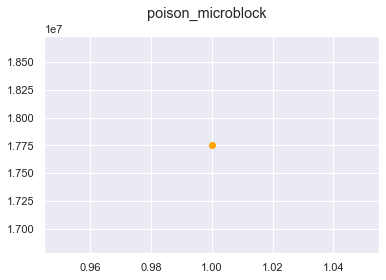

,a,b
cost_analysis_type_annotate,2234.452952721274,8169.458349
cost_analysis_type_check,76969.66136293246,0.0
cost_analysis_type_lookup,956.9688462228495,3762.017749
cost_analysis_visit,0.0,9964.808442
cost_analysis_iterable_func,158117.16979260228,0.0
cost_analysis_option_cons,0.0,36222.64787
cost_analysis_option_check,0.0,70903.532242
cost_analysis_bind_name,8909.210420822972,104817.426723
cost_analysis_list_items_check,15287.6603839448,3553.710489887868
cost_analysis_check_tuple_get,18.588528704900316,1202.763112


In [39]:
output = pd.DataFrame(columns=["a", "b"])

estimate_plot(df, 'cost_analysis_type_annotate', output)
estimate_plot(df, 'cost_analysis_type_check', output)
estimate_plot(df, 'cost_analysis_type_lookup', output)
estimate_plot(df, 'cost_analysis_visit', output)
estimate_plot(df, 'cost_analysis_iterable_func', output)
estimate_plot(df, 'cost_analysis_option_cons', output)
estimate_plot(df, 'cost_analysis_option_check', output)
estimate_plot(df, 'cost_analysis_bind_name', output)
estimate_plot(df, 'cost_analysis_list_items_check', output)
estimate_plot(df, 'cost_analysis_check_tuple_get', output, nlogn)
# estimate_plot(df, 'cost_analysis_check_tuple_merge ', output)
estimate_plot(df, 'cost_analysis_check_tuple_cons', output, nlogn)
estimate_plot(df, 'cost_analysis_tuple_items_check', output)
estimate_plot(df, 'cost_analysis_check_let', output)
estimate_plot(df, 'cost_analysis_lookup_function', output)
estimate_plot(df, 'cost_analysis_lookup_function_types', output)
estimate_plot(df, 'cost_analysis_lookup_variable_const', output)
estimate_plot(df, 'cost_analysis_lookup_variable_depth', output, nlogn)
estimate_plot(df, 'cost_arithmetic_only_checker', output)
estimate_plot(df, 'cost_read_only', output)
estimate_plot(df, 'cost_trait_checker', output)
estimate_plot(df, 'cost_type_checker', output)
estimate_plot(df, 'cost_ast_parse', output)
estimate_plot(df, 'cost_ast_cycle_detection', output)
estimate_plot(df, 'cost_analysis_storage', output)
estimate_plot(df, 'cost_analysis_use_trait_entry', output)
estimate_plot(df, 'cost_analysis_get_function_entry', output)
# do we have a benchmark for this?
# estimate_plot(df, 'cost_analysis_fetch_contract_entry', output)
estimate_plot(df, 'cost_lookup_variable_depth', output)
estimate_plot(df, 'cost_lookup_variable_size', output)
estimate_plot(df, 'cost_lookup_function', output)
estimate_plot(df, 'cost_bind_name', output)
estimate_plot(df, 'cost_inner_type_check_cost', output)
estimate_plot(df, 'cost_user_function_application', output)
estimate_plot(df, 'cost_let', output)
estimate_plot(df, 'cost_if', output)
estimate_plot(df, 'cost_asserts', output)
estimate_plot(df, 'cost_map', output)
estimate_plot(df, 'cost_filter', output)
estimate_plot(df, 'cost_len', output)
estimate_plot(df, 'cost_element_at', output)
estimate_plot(df, 'cost_index_of', output)
estimate_plot(df, 'cost_fold', output)
estimate_plot(df, 'cost_list_cons', output)
estimate_plot(df, 'cost_type_parse_step', output)
estimate_plot(df, 'cost_tuple_get', output, nlogn)
estimate_plot(df, 'cost_tuple_merge', output)
estimate_plot(df, 'cost_tuple_cons', output, nlogn)
estimate_plot(df, 'cost_add', output)
estimate_plot(df, 'cost_sub', output)
estimate_plot(df, 'cost_mul', output)
estimate_plot(df, 'cost_div', output)
estimate_plot(df, 'cost_geq', output)
estimate_plot(df, 'cost_leq', output)
estimate_plot(df, 'cost_le', output)
estimate_plot(df, 'cost_ge', output)
estimate_plot(df, 'cost_int_cast', output)
estimate_plot(df, 'cost_mod', output)
estimate_plot(df, 'cost_pow', output)
estimate_plot(df, 'cost_sqrti', output)
estimate_plot(df, 'cost_log2', output)
estimate_plot(df, 'cost_xor', output)
estimate_plot(df, 'cost_not', output)
estimate_plot(df, 'cost_eq', output)
estimate_plot(df, 'cost_begin', output)
estimate_plot(df, 'cost_hash160', output)
estimate_plot(df, 'cost_sha256', output)
estimate_plot(df, 'cost_sha512', output)
estimate_plot(df, 'cost_sha512t256', output)
estimate_plot(df, 'cost_keccak256', output)
estimate_plot(df, 'cost_secp256k1recover', output)
estimate_plot(df, 'cost_secp256k1verify', output)
estimate_plot(df, 'cost_print', output)
estimate_plot(df, 'cost_some_cons', output)
estimate_plot(df, 'cost_ok_cons', output)
estimate_plot(df, 'cost_err_cons', output)
estimate_plot(df, 'cost_default_to', output)
estimate_plot(df, 'cost_unwrap_ret', output)
estimate_plot(df, 'cost_unwrap_err_or_ret', output)
estimate_plot(df, 'cost_is_okay', output)
estimate_plot(df, 'cost_is_none', output)
estimate_plot(df, 'cost_is_err', output)
estimate_plot(df, 'cost_is_some', output)
estimate_plot(df, 'cost_unwrap', output)
estimate_plot(df, 'cost_unwrap_err', output)
estimate_plot(df, 'cost_try_ret', output)
estimate_plot(df, 'cost_match', output)
estimate_plot(df, 'cost_or', output)
estimate_plot(df, 'cost_and', output)
estimate_plot(df, 'cost_append', output)
estimate_plot(df, 'cost_concat', output)
estimate_plot(df, 'cost_as_max_len', output)
estimate_plot(df, 'cost_contract_call', output)
estimate_plot(df, 'cost_contract_of', output)
estimate_plot(df, 'cost_principal_of', output)
estimate_plot(df, 'cost_at_block', output)
estimate_plot(df, 'cost_load_contract', output)
estimate_plot(df, 'cost_create_map', output)
estimate_plot(df, 'cost_create_var', output)
estimate_plot(df, 'cost_create_nft', output)
estimate_plot(df, 'cost_create_ft', output)
estimate_plot(df, 'cost_fetch_entry', output)
estimate_plot(df, 'cost_set_entry', output)
estimate_plot(df, 'cost_fetch_var', output)
estimate_plot(df, 'cost_set_var', output)
estimate_plot(df, 'cost_contract_storage', output)
estimate_plot(df, 'cost_block_info', output)
estimate_plot(df, 'cost_stx_balance', output)
estimate_plot(df, 'cost_stx_transfer', output)
estimate_plot(df, 'cost_ft_mint', output)
estimate_plot(df, 'cost_ft_transfer', output)
estimate_plot(df, 'cost_ft_balance', output)
estimate_plot(df, 'cost_nft_mint', output)
estimate_plot(df, 'cost_nft_transfer', output)
estimate_plot(df, 'cost_nft_owner', output)
estimate_plot(df, 'cost_ft_get_supply', output)
estimate_plot(df, 'cost_ft_burn', output)
estimate_plot(df, 'cost_nft_burn', output)
estimate_plot(df, 'poison_microblock', output)

output

In [5]:
output.to_csv("cost_constants.csv")

In [9]:
71241.3539776112 2.126736e+07

SyntaxError: invalid syntax (<ipython-input-9-1110dabad65a>, line 1)